# Partes del notebook:
- Introducción
- Carga de datos.
- Procesamiento de la image. Diferencia de colores usando el modelo LAB.
- Análisis de las componentes conexas.

## Introducción

En este notebook se presenta un prototipo para el análisis oclusal.
La aplicación se divide en carga de datos, procesamiento de la imagen y análisis de la imagen.

## Carga de datos

In [10]:
%matplotlib tk
from tkinter import *
from tkinter.filedialog import askopenfilename
from tkinter.messagebox import showerror

fname = "" # Esto va a ser el nombre del archivo

class MyFrame(Frame):
    def __init__(self):
        Frame.__init__(self)
        self.master.title("Carga Imágenes")
        self.master.rowconfigure(5, weight=1)
        self.master.columnconfigure(5, weight=1)
        self.grid(sticky=W+E+N+S)

        self.button = Button(self, text="Explora", command=self.load_file, width=10)
        self.button.grid(row=1, column=0, sticky=W)

    def load_file(self):
        global fname
        global root
    
        fname = askopenfilename(filetypes=(("Imagenes", "*.jpg"),
                                           ("Imagenes", "*.JPG"),
                                           ("All files", "*.*") ))
        if fname:
            try:
                print(fname)
            except:                     
                showerror("Fallos al cargar el fichero", "Failed to read file\n'%s'" % fname)
            return
        


root = MyFrame()

In [11]:
# O más rápido, decir explicitamente la imagen a cargar
fname = "C:/Users/andro/Documents/Workspace GitHub/PrawnView/docs/img/100-120.jpg"

In [12]:
print("Se va a cargar la imagen contenida en ",fname)

Se va a cargar la imagen contenida en  C:/Users/andro/Documents/Workspace GitHub/PrawnView/docs/img/100-120.jpg


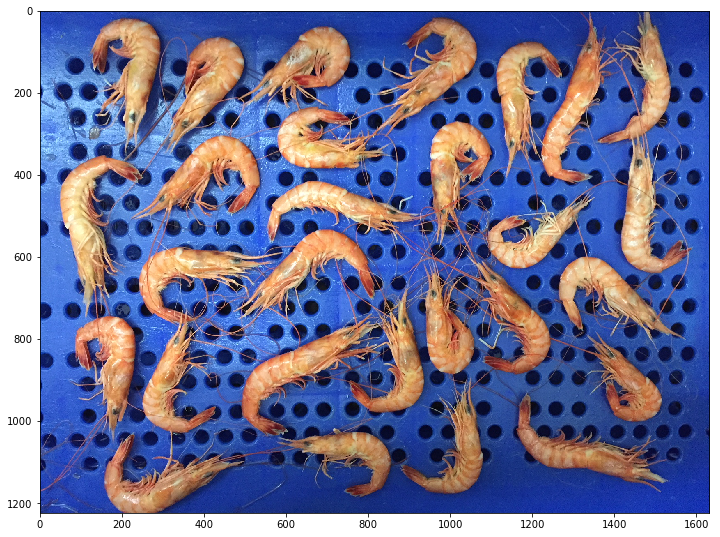

In [17]:
%matplotlib inline
 

from skimage import io # necesario para leer imágenes
import matplotlib.pyplot as plt #matplotlib es necesario para mostrar gráficos
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import cv2

# Nota, se podría reducir el tamaño de todas las imágenes para acelerar
imgGrande = io.imread(fname)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(imgGrande, cmap=plt.cm.gray)



## Procesamiento de la imagen


In [14]:

# en skimage se puede pasar de RGB a lab con la función  rgb2lab
from skimage.color import rgb2lab





In [248]:
'''
Función que transforma un número en base 255 en otro en base 1.
'''

def base1(num):
    valorEnBase255 = num
    valorEnBase1 = (valorEnBase255/255)*1
    return valorEnBase1
    
print(base1(255))
print(base1(200))
print(base1(25.5))

1.0
0.7843137254901961
0.1


In [249]:
'''
Función para pasar un pixel de RGB a CIELAB

CIELAB es más apropiado para hacer diferencia de colores
'''
def pixelRGB2LAB(pixel):
    r,g,b = pixel # pixel es una lista con 3 valores, los puedo guardar en 3 variables asi
    rBase1 = base1(r)
    gBase1 = base1(g)
    bBase1 = base1(b)
    
    
    # rgb2lab espera una lista3D, así que le paso el pixel dentro 
    # de una lista de listas y para sacarlo igual.
    return rgb2lab([[[rBase1,gBase1,bBase1]]])[0][0]

In [250]:
'''
Función que recibe 3 parámetros: imagen, color y umbral.
Convierte imagen y color al modelo LAB
Realiza la diferencia de color entre cada uno de los pixels de la imagen y el color pasado como parámetro
Y posteriormente realiza la binarización usando el umbral.
'''

def diferenciaColorLab(imagen,color,umbral):
    print("diferenciaColorLab")
    imagenLab = rgb2lab(imagen)
    colorLab = pixelRGB2LAB(color)
    imagenLab2 = abs(imagenLab-color).mean(axis=2)
    imagenLab3 = imagenLab2 < umbral
    return imagenLab3

diferenciaColorLab


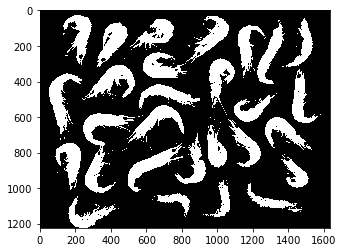

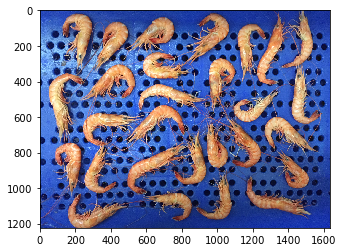

In [251]:
# Ejemplos de uso de las funciones.

# actualiza la ruta


pathPequeImg=fname
imgPeque = io.imread(pathPequeImg)
                                        # color RGB de un pixel de dentro de la gamba cogido con gimp
diffCLab = diferenciaColorLab(imgPeque, [ 247,211,114], 160)

plt.imshow(diffCLab,cmap=cm.gray)
plt.figure()
plt.imshow(imgPeque)

## Morfología matemática

http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_morphology.html

Morphological opening on an image is defined as an erosion followed by a dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks.


Morphological closing on an image is defined as a dilation followed by an erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks.



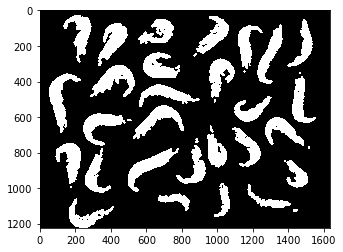

In [252]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

selem = disk(6)



opImg = opening(diffCLab, selem)
plt.imshow(opImg,cmap=cm.gray)


## Funcion para la talla de la materia prima

In [253]:
'''
Función que manea las diferentes tallas de la materia prima
No recibe ningun parámetro
Pide por teclasdo los dos parametros pertenecientes al numero de unidades por caja(ejemplo 50/60)
Devuelve_________________________________________________
'''

def tallaProducto():
    print("Introducir la talla del producto en el siguiente formato talla1/talla2 (ej 50/60):")
    print("Tallas a elegir:30/40 - 40/50 - 50/60 - 70/80 - 80/100 - 100/120")
    talla1=int(input("\t-Talla1:"))
    talla2=int(input("\t-Talla2:"))
    areas1 = { 30: 40000, 40: 31500, 50: 28000, 70: 25500, 80: 25000, 100: 22100}
    areas2 = { 40: 18800, 50: 18000, 60: 14500, 80: 14500, 100: 14550, 120: 8000 }
    longitudes = { 20: 100, 30: 150, 40: 200, 50: 250, 60: 300, 80: 400, 100: 500, 120: 600 }
    area1 = areas1[talla1]
    area2 = areas2[talla2]
    longitud1 = longitudes[talla1]
    longitud2 = longitudes[talla2]  
    return 8000,100000,1,2#area1,area2,longitud1,longitud2


## Función para sacar las propiedades de la region

In [254]:
def propRegion(region):
    #print("__________",region,"___________")
    print("--region.area:",region.area)

'''
    print("--region.bbox:",region.bbox)
    print("--region.bbox_area:",region.bbox_area)
    print("--region.centroid:",region.centroid)
    print("--region.convex_area:",region.convex_area)
    print("--region.convex_image",region.convex_image)
    print("--region.coords:",region.coords)
    print("--region.eccentricity:",region.eccentricity)
    print("--equivalent_diameter:",region.equivalent_diameter)  
    print("--euler_number:",region.euler_number)  
    print("--extent :",region.extent )  
    print("--filled_area:",region.filled_area)  
    print("--filled_image:",region.filled_image)
    print("--image:",region.image)    
    print("--inertia_tensor:",region.inertia_tensor )    
    print("--inertia_tensor_eigvals:",region.inertia_tensor_eigvals)    
    #print("--intensity_image:",region.intensity_image)    
    print("--label:",region.label)    
    #print("--local_centroid:",region.local_centroid )    
    print("--major_axis_length:",region.major_axis_length)    
    #print("--max_intensity:",region.max_intensity)    
    #print("--mean_intensity:",region.mean_intensity)    
    #print("--min_intensity :",region.min_intensity )    
    print("--minor_axis_length :",region.minor_axis_length )    
    print("--moments:",region.moments)    
    print("--moments_central :",region.moments_central )    
    print("--moments_hu:",region.moments_hu)    
    print("--moments_normalized:",region.moments_normalized)    
    print("--orientation:",region.orientation)
    print("--perimeter:",region.perimeter)
    print("--solidity :",region.solidity )

#________________________COMENTADO____________________

    print("--weighted_centroid:",region.weighted_centroid) 
    print("--weighted_local_centroid:",region.weighted_local_centroid)    
    print("--weighted_moments:",region.weighted_moments)    
    print("--weighted_moments_central :",region.weighted_moments_central )    
    print("--weighted_moments_hu:",region.weighted_moments_hu)    
    print("--weighted_moments_normalized :",region.weighted_moments_normalized )      

#____________________________________________________


print("____________________________________________________________________________________________")
print("\n")
analiza(imgPeque,opImg)
print("--Número de pixels de la region(region.area).")
print("--Cuadro delimitador (min_row, min_col, max_row, max_col). Los píxeles que pertenecen al cuadro delimitador están en el intervalo medio abierto [min_row; max_row) y [min_col; max_col).(region.bbox).")
print("--Número de pixels del cuadro delimitador(region.bbox_area).")
print("--Tupla de coordenadas del centroide(region.centroid).")
print("--Número de píxeles de la imagen convexa del casco(region.convex_area).")
print("--Imagen binaria convexa del casco que tiene el mismo tamaño que el cuadro delimitador(region.convex_image).")
print("--Lista de coordenadas (fila, col) de la región (region.coords).")    
print("--Excentricidad de la elipse que tiene los mismos segundos segundos que la región. La excentricidad es la relación de la distancia focal (distancia entre los puntos focales) sobre la longitud del eje principal. El valor está en el intervalo [0, 1). Cuando es 0, la elipse se convierte en un círculo(region.eccentricity).")     
print("--El diámetro de un círculo con la misma área que la región(equivalent_diameter).")     
print("--Proporción de píxeles en la región a píxeles en el cuadro delimitador total. Calculado como área / (rows * cols)(region.extent).") 
print("--Número de píxeles de la región llena(region.filled_area).")  
print("--Imagen de región binaria con agujeros llenos que tiene el mismo tamaño que el cuadro delimitador.(region.filled_image).")   
print("--Imagen de región binaria en rodajas que tiene el mismo tamaño que el cuadro delimitador.(region.).image") 
print("--Tensor de inercia de la región para la rotación alrededor de su masa(region.inertia_tensor).")
print("--Los dos valores propios del tensor de inercia en orden decreciente(region.inertia_tensor_eigvals).")  
print("--Imagen dentro del cuadro delimitador de la región(region.intensity_image).") 
print("--La etiqueta en la imagen de entrada etiquetada(region.label).") 
print("--Tupla de coordenadas del centroide (fila, col), relativa al cuadro delimitador de la región(region.local_centroid ).")  
print("--La longitud del eje principal de la elipse que tiene los mismos segundos momentos centrales normalizados que la región.(region.major_axis_length).") 
print("--Valor con la mayor intensidad en la región.(region.max_intensity).") 
print("--Valor con la intensidad media en la región.(region.mean_intensity).")  
print("--Valor con la menor intensidad en la región.(region.min_intensity ).") 
print("--Momentos espaciales hasta el 3er orden:m_ji = sum {array (x, y) * x ^ j * y ^ i}donde la suma está sobre las coordenadas x, y de la región.(region.moments).") 
print("--Hu momentos (traducción, escala y rotación invariante).(region.moments_central ).")
print("--Momentos normalizados (traducción e invariante de escala) hasta el 3er orden:nu_ji = mu_ji / m_00 ^ [(i + j) / 2 + 1]donde m_00 es el momento espacial zeroth.(region.moments_normalized).")
print("--Ángulo entre el eje X y el eje mayor de la elipse que tiene los mismos segundos segundos que la región. Que van desde -pi / 2 a pi / 2 en sentido contrario a las agujas del reloj.(region.orientation).")
print("--Perímetro del objeto que aproxima el contorno como una línea a través de los centros de los píxeles del borde utilizando una conectividad de 4.(region.perimeter).")
print("--Proporción de píxeles en la región a píxeles de la imagen del casco convexo(region.solidity ).")

#________________________COMENTADO____________________

print("--(region.weighted_centroid).")
print("--(region.weighted_local_centroid).")
print("--(region.weighted_moments).")
print("--(region.weighted_moments_central ).")
print("--(region.weighted_moments_hu).")
'''
#____________________________________________________
print("____________________________________________________________________________________________")
print("\n")
    

____________________________________________________________________________________________




## análisis 
- parte 1: Analisis de componentes conexas

### Análisis parte 1

Mira este enlace con la lista de atributos que se puede sacar de una región
http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [255]:
# imports necesarios para hacer el análisis de componentes conexas
from skimage.measure import label
from skimage.measure import regionprops

In [256]:
'''
Función que realiza el análisis de componentes conexas.
Recibe 2 imágenes: la primera de color y la segunda en blanco y negro.
Realizará la búsqueda de componentes conexas sobre la segunda, la primera se usa solo para mostrarla.
Devuelve los anchos y los largos de cada una de las componentes encontradas.
'''

def analiza(img,imgBN):
    
    anchoRegion = []
    largoRegion = []
    
    # crea una figura con dos subfiguras
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 16))
    
    # hace las etiquetas de los ejes invisibles
    ax[0].yaxis.set_visible(False)
    ax[0].xaxis.set_visible(False)
    
    ax[1].yaxis.set_visible(False)
    ax[1].xaxis.set_visible(False)
    
    # en la primera subfigura está la imagen original
    ax[0].imshow(img)
    
    # en la segunda subfigura está la imagen en blanco y negro con las regiones encontradas
    ax[1].imshow(imgBN, cmap=plt.cm.gray)
    
    
    # label es la primera función clave, toma una imagen en blanco y negro
    # y devuelve sus componentes conexas
    label_image = label(imgBN)

    # regionprops es la segunda función clave, toma las componentes conexas
    # y devuelve una lista
    
    
    a1,a2,l1,l2=tallaProducto()#8000,20000,0,100000
    print(a1,a2,l1,l2)


    
    for region in regionprops(label_image):
        
        #aqui de una region se puede sacar área y muchas otras cosas 
        
        # draw rectangle around segmented regions
        minr, minc, maxr, maxc = region.bbox
        # skip small images
        if region.area < a1 or region.area > a2:  # esto se debería parametrizar
            continue   
        propRegion(region)
        # draw rectangle around segmented regions
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
        ax[1].add_patch(rect)
        # fijaos que aqui arriba se saca el área, así se pueden sacar todos los demás valores  
        # region es un objeto que describe todas las propiedades de la región
        anchoRegion.append(region.minor_axis_length)
        largoRegion.append(region.major_axis_length)
        '''
                if region.area > a1*2:
            anchoRegion.append(region.minor_axis_length)
            largoRegion.append(region.major_axis_length)'''


        
    plt.tight_layout()
    plt.show()

    return anchoRegion,largoRegion
    

# Ejemplo de uso de la función analiza

ancho,largo=
print("Anchos y largos de las regiones analizadas")
print(ancho,largo)

In [257]:
from IPython.display import display
from ipywidgets import widgets, interact, interactive, fixed

cp = widgets.ColorPicker()
cp.value = '#%02x%02x%02x' % (247,211,114)
display(cp)

Introducir la talla del producto en el siguiente formato talla1/talla2 (ej 50/60):
Tallas a elegir:30/40 - 40/50 - 50/60 - 70/80 - 80/100 - 100/120
	-Talla1:100
	-Talla2:120
8000 100000 1 2
--region.area: 18013
--region.area: 17057
--region.area: 15759
--region.area: 13319
--region.area: 19727
--region.area: 18482
--region.area: 15177
--region.area: 18928
--region.area: 17980
--region.area: 22002
--region.area: 22012
--region.area: 15875
--region.area: 17075
--region.area: 13394
--region.area: 19432
--region.area: 18999
--region.area: 16073
--region.area: 14222
--region.area: 14254
--region.area: 17845
--region.area: 13762
--region.area: 14520
--region.area: 21060
--region.area: 10653
--region.area: 8233
--region.area: 9549
--region.area: 8020
--region.area: 15186


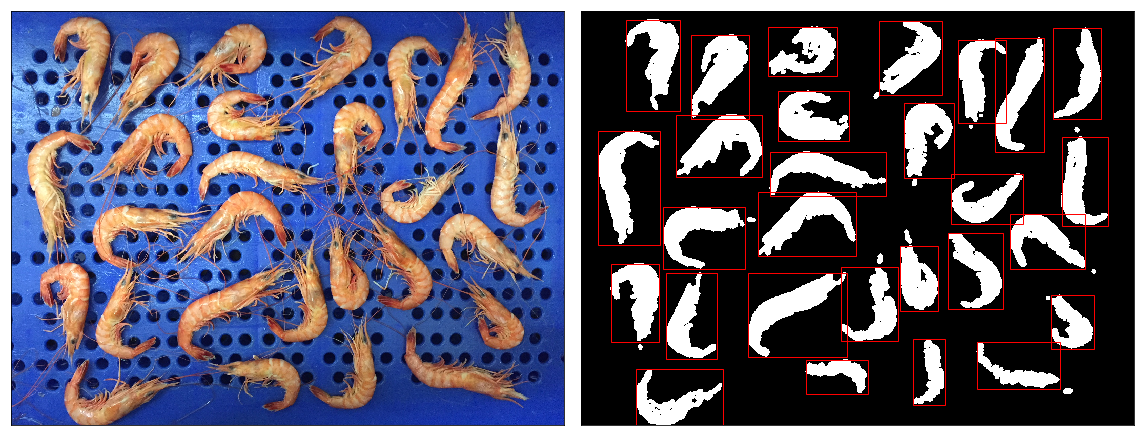

([129.42846413483616,
  111.91139709164494,
  130.05092259570927,
  93.60403430765129,
  115.32132710748017,
  80.89048806314669,
  103.42038708877293,
  146.73450972414565,
  133.99214656367053,
  161.48906311755988,
  134.4638005151427,
  98.78474608332509,
  101.31896413513145,
  119.9835383005234,
  144.12972406060763,
  156.3826536113356,
  137.58730422005385,
  114.54998134049413,
  103.44504906999465,
  130.32354791809828,
  129.19960214242826,
  118.9668574467816,
  102.02528551516444,
  108.19319850085469,
  70.15165070391654,
  74.08063107735157,
  71.31799541558266,
  140.01352160486414],
 [264.03862056402414,
  256.2073130491512,
  217.45119194349257,
  288.48851969514294,
  256.1522306137851,
  370.56537217463233,
  266.6262131740899,
  215.85035033808475,
  227.47916833680566,
  271.88491330884267,
  359.52778190704,
  296.96754393621296,
  347.1341476895128,
  231.53188745209053,
  324.0676356094925,
  265.761099506946,
  250.20522281215722,
  258.7661412743418,
  192.57

In [258]:
analiza(imgPeque,opImg)

In [259]:
#Aquí es donde teneis que meter mano.


def ejecuta(img,umbral):
    valorHex= cp.value
    rojoHex = valorHex[1:3]
    verdeHex = valorHex[3:5]
    azulHex = valorHex[5:7]
    
    rojoRGB = int(rojoHex, 16)
    verdeRGB = int(verdeHex, 16)
    azulRGB = int(azulHex, 16)
    
    color = [rojoRGB,verdeRGB,azulRGB]
    

    diff=diferenciaColorLab(img,color,umbral)
    opImg = opening(diff, selem)
    #plt.imshow(diff,cmap=cm.gray,interpolation='none')
    anchos,largos = analiza(opImg,opImg)
    
    
    print("Número de objetos: ",len(anchos))
    
        
    
    
    



In [260]:
interactive(ejecuta,img=fixed(imgGrande),umbral=(140,180))

C:\Users\andro\Anaconda3\lib\site-packages\traitlets\traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


	-Talla1:100
	-Talla2:120
